In [1]:
import sys
from pathlib import Path
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
import dlib
src = Path.cwd().parent / 'src'
sys.path.append(str(src))

from config import PREPROCESSED_DATA_DIR

In [29]:
classifier_path = str(src / 'external_utils/haarcascade_frontalface_default.xml')
classifier = cv2.CascadeClassifier(classifier_path)

In [8]:
h5_file = h5py.File(PREPROCESSED_DATA_DIR / 'videos.h5')

In [28]:
def get_face_coordinates(h5_file: h5py.File, dataset_name: str, classifier: cv2.CascadeClassifier) -> tuple[int]:
    idx = 0
    while True:
        frame = h5_file[dataset_name][idx]
        faces = classifier.detectMultiScale(frame)
        try:
            return faces[0].tolist()
        except IndexError:
            idx += 1

In [26]:
def crop_frames(h5_file: h5py.File, dataset_name: str, x, y, w, h) -> np.ndarray:
    pady = 30
    return np.array(h5_file[dataset_name][:, y - pady:y+h, x:x+w, :])

In [74]:
predictor_path = str(src / 'external_utils/shape_predictor_81_face_landmarks.dat')
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor(predictor_path)

In [75]:
def get_landmarks(frames: np.ndarray, detector, predictor):
    idx = 0
    while True:
        frame = cv2.cvtColor(frames[idx], cv2.COLOR_RGB2GRAY)
        face = detector(frame)[0]
        landmarks = predictor(frame, face)
        return [(landmarks.part(i).x, landmarks.part(i).y) for i in range(81)]

In [77]:
face_coordinates = get_face_coordinates(h5_file, 'P1H1', classifier)
cropped_frames = crop_frames(h5_file, 'P1H1', *face_coordinates)
landmarks = get_landmarks(cropped_frames, face_detector, landmark_predictor)

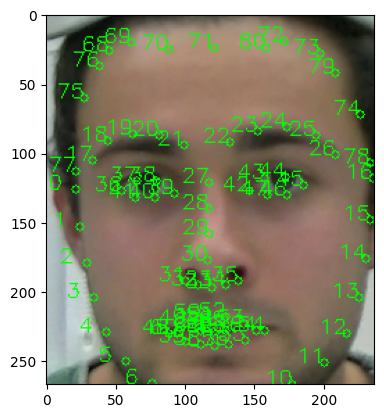

In [78]:
frame = cropped_frames[30].copy()
for i, landmark in enumerate(landmarks):
    cv2.circle(frame, landmark, radius=3, color=(0, 255, 0))
    cv2.putText(frame, str(i), (landmark[0] - 20, landmark[1]), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 0))
plt.imshow(frame)

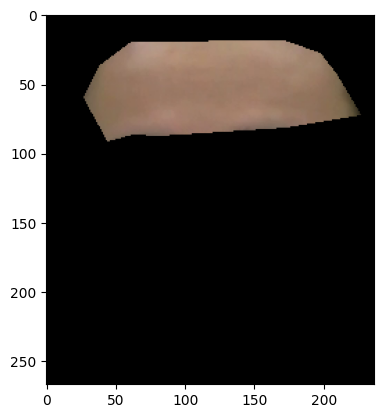

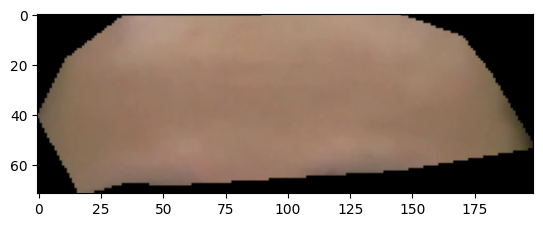

In [204]:
frame = cropped_frames[50].copy()
mask = np.zeros_like(frame)

forehead_coordinates = [landmarks[i] for i in (24, 74, 79, 73, 72, 69, 76, 75, 18, 19, 20)]
forehead_coordinates = np.expand_dims(np.array(forehead_coordinates, dtype=np.int32), 0)
cv2.fillPoly(mask, forehead_coordinates, [255] * 3)    
masked_image = cv2.bitwise_and(frame, mask)

x_min, x_max, y_min, y_max = (forehead_coordinates[..., 0].min(),
                              forehead_coordinates[..., 0].max(),
                              forehead_coordinates[..., 1].min(),
                              forehead_coordinates[..., 1].max()
                              )
plt.imshow(masked_image)
plt.show()
plt.imshow(masked_image[y_min:y_max, x_min:x_max, :])
plt.show()

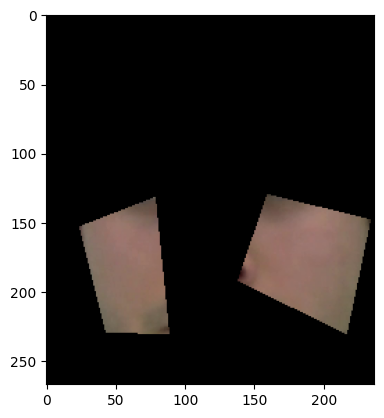

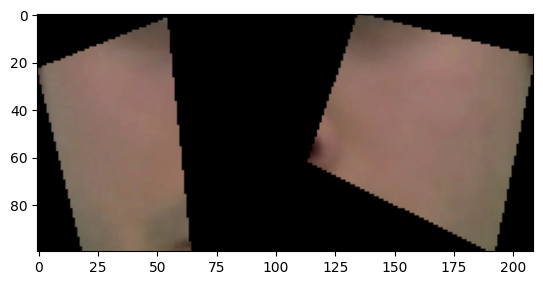

In [206]:
frame = cropped_frames[50].copy()
mask = np.zeros_like(frame)

cheeks_coordinates = [[landmarks[i] for i in (15, 47, 35, 12)],
                      [landmarks[i] for i in (1, 40, 48, 4)]]
cheeks_coordinates = np.array(cheeks_coordinates, dtype=np.int32)
cv2.fillPoly(mask, cheeks_coordinates, [255] * 3)    
masked_image = cv2.bitwise_and(frame, mask)

x_min, x_max, y_min, y_max = (cheeks_coordinates[..., 0].min(),
                              cheeks_coordinates[..., 0].max(),
                              cheeks_coordinates[..., 1].min(),
                              cheeks_coordinates[..., 1].max()
                              )
plt.imshow(masked_image)
plt.show()
plt.imshow(masked_image[y_min:y_max, x_min:x_max, :])
plt.show()

In [ ]:
def get_forehead_cheeks_regions(frames: np.ndarray) -> tuple:
    # https://stackoverflow.com/a/15343106/13226209
    